# Anomaly Detection Using Facebook Prophet for NY Taxi Data

The purpose of this notebook is to explore Facebook Prophet and how it can be used to find anomalies in time series data. The dataset is of NY City taxi data, which has two columns.
- Timestamp: the date and time in 30 minute intervals
- Value: the number of taxi rides during that 30 minute interval 

**Objective:** Discover anomalies and determine whether they are important for forecasting the future demand of taxi demand. Or is the anomaly something that cannot be predicted in the future and is not helpful in training future models.

This notebook is walkthrough of the tutorial found here ['Analytics Vidhya']('https://www.analyticsvidhya.com/?p=87045')

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
from fbprophet import Prophet

import warnings

warnings.simplefilter("ignore", UserWarning)

In [40]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [41]:
# import the new york taxi data
df = pd.read_csv('ny_taxi.csv')
df.shape

(10320, 2)

In [42]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


### The value column is the count of taxi trips for every half-hour interval

In [43]:
# convert the timestamp from string to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

## Resample the data on an hourly interval

In [44]:
df = df.set_index('timestamp').resample('H').mean()
df.shape

(5160, 1)

In [45]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5


In [46]:
df.tail()

,value
timestamp,
2015-01-31 19:00:00,28288.5
2015-01-31 20:00:00,24138.0
2015-01-31 21:00:00,24194.5
2015-01-31 22:00:00,26515.0
2015-01-31 23:00:00,26439.5


## Plot the Time Series Data

In [47]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi Demand')

# slider
fig.update_xaxes(
            rangeslider_visible=True,
            rangeselector=dict(
                            buttons = list([
                                dict(count=1, label='1y', step='year', stepmode='backward'),
                                dict(count=2, label='2y', step='year', stepmode='backward'),
                                dict(count=2, label='5y', step='year', stepmode='backward')
                            ])
            )
)

fig.show()


In [48]:
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 'value':'y'}, axis='columns')

In [49]:
taxi_df.head()

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


## Create a train and test set

Training dataset will be from July 1, 2014 to January 27, 2015

Testing dataset will be from January 28, 2015 to January 31, 2015

In [50]:
# train test split
train_df = taxi_df[(taxi_df['ds'] >= '2014-07-01') & (taxi_df['ds'] <= '2015-01-27')]
test_df = taxi_df[(taxi_df['ds'] > '2015-01-28')]

## Create Prophet Model

In [51]:
# create a model with a 95 percent confidence interval
model = Prophet(changepoint_range=0.95)

In [52]:
model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [53]:
# create a future dataframe with hourly frequencies
future_df = model.make_future_dataframe(periods=119, freq='H')

## Make Forecast

In [54]:
forecast_df = model.predict(future_df)
forecast_df.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
5155,2015-01-31 19:00:00,14359.655535,19592.838891,28274.143364,14351.045824,14367.965365,9410.562654,9410.562654,9410.562654,7236.073346,7236.073346,7236.073346,2174.489308,2174.489308,2174.489308,0.0,0.0,0.0,23770.218189
5156,2015-01-31 20:00:00,14359.639595,19701.951798,29062.882788,14350.766674,14368.300678,9974.585862,9974.585862,9974.585862,7906.172319,7906.172319,7906.172319,2068.413544,2068.413544,2068.413544,0.0,0.0,0.0,24334.225457
5157,2015-01-31 21:00:00,14359.623655,18463.252647,27634.910352,14350.496727,14368.536061,8851.278662,8851.278662,8851.278662,6901.634420,6901.634420,6901.634420,1949.644242,1949.644242,1949.644242,0.0,0.0,0.0,23210.902317
5158,2015-01-31 22:00:00,14359.607714,16320.875294,26017.068571,14350.226037,14368.624021,6659.330326,6659.330326,6659.330326,4840.625053,4840.625053,4840.625053,1818.705273,1818.705273,1818.705273,0.0,0.0,0.0,21018.938040
5159,2015-01-31 23:00:00,14359.591774,13908.395940,23293.650070,14350.027783,14368.694408,4132.198591,4132.198591,4132.198591,2455.968843,2455.968843,2455.968843,1676.229748,1676.229748,1676.229748,0.0,0.0,0.0,18491.790365


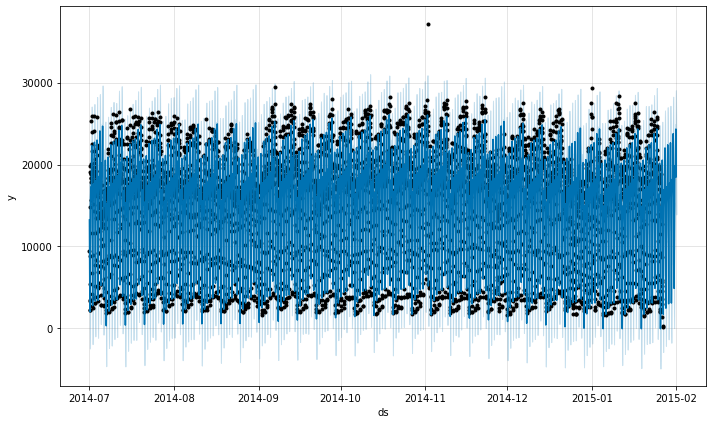

In [55]:
fig1 = model.plot(forecast_df)

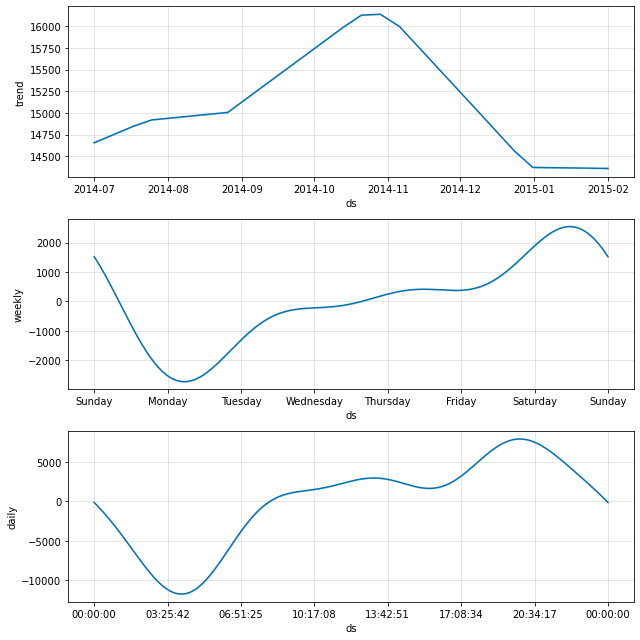

In [56]:
# view the trendlines
comp = model.plot_components(forecast_df)

## Analysis of the Trends
The yearly data shows that from July to the end of October, there is an increasing trend of taxi rides. Then it declines from November down to January and February

The weekly data shows that Monday is the lowest number of rides typically, and it increases throughout the week. The peak is on Saturday night and then it starts decline on Sunday back to a low on Monday morning.

The daily data shows that there is the lowest demand for taxi rides at around 4am, then it starts picking up throughout the morning and is relatively flat during the day time hours of 10am to 5pm. There is a peak at around 8pm, which is expected as that is the time when people get off work and want to take a taxi somewhere.  

This data is important in that it can be used in determining contextual outliers that would likely be missed if only comparing to global outliers.

## Anomaly Detection

In [57]:
# concatenate the forecast data and the raw hourly data
result_df = pd.concat([taxi_df.set_index('ds')['y'], forecast_df.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper' ]]], axis=1)
result_df.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13229.889231,8484.590520,17777.484546
2014-07-01 01:00:00,5433.0,10221.675230,5770.053409,15296.677950
2014-07-01 02:00:00,3346.5,6658.313453,2268.176045,11771.085075
2014-07-01 03:00:00,2216.5,3437.280900,-1188.886114,8380.078656
2014-07-01 04:00:00,2189.5,2006.634944,-2472.421043,6495.219759


In [58]:
# create a column for the difference in prediction vs actual
result_df['error'] = result_df['y'] - result_df['yhat']

# create a column for the confidence range
result_df['uncertainty'] = result_df['yhat_upper'] - result_df['yhat_lower']

result_df.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-07-01 00:00:00,9485.5,13229.889231,8484.590520,17777.484546,-3744.389231,9292.894026
2014-07-01 01:00:00,5433.0,10221.675230,5770.053409,15296.677950,-4788.675230,9526.624540
2014-07-01 02:00:00,3346.5,6658.313453,2268.176045,11771.085075,-3311.813453,9502.909030
2014-07-01 03:00:00,2216.5,3437.280900,-1188.886114,8380.078656,-1220.780900,9568.964770
2014-07-01 04:00:00,2189.5,2006.634944,-2472.421043,6495.219759,182.865056,8967.640802


### Find rows where the absolute error is more than 1.5 times the uncertainty

In [59]:
result_df[result_df['error'].abs() > 1.5*result_df['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-11-02 01:00:00,37204.5,14197.262497,9610.870771,18741.301463,23007.237503,9130.430693
2015-01-01 01:00:00,29292.0,11423.425494,6784.716006,15990.291575,17868.574506,9205.575569
2015-01-01 02:00:00,25753.5,7787.925675,3142.166126,12557.730450,17965.574325,9415.564324
2015-01-01 03:00:00,22067.0,4496.745757,-367.139041,8985.122356,17570.254243,9352.261398
2015-01-26 19:00:00,4565.5,19767.226446,15498.798707,24249.837981,-15201.726446,8751.039273
2015-01-26 20:00:00,3630.5,20542.469852,16260.110008,25226.091450,-16911.969852,8965.981442
2015-01-26 21:00:00,2907.0,19643.580037,14849.540640,24445.709575,-16736.580037,9596.168936
2015-01-26 22:00:00,1324.5,17687.836451,12819.365601,22328.852484,-16363.336451,9509.486882


## Analysis of the Anomalies
There are only three dates where the taxi demand was more than 1.5 times the confidence interval.

**November 2, 2014** was the New York City Marathon, so many people were visiting from out of town and needing a taxi.

**January 1, 2015** was New Years morning, which is typically a morning where more people are out celebrating than normal.

**January 26, 2015** was a major snowstorm that hit New York. If the snowstorm was bad enough, perhaps people could not safely leave their house and perhaps taxis could not safely drive around.

## Visualize the Anomalies

In [60]:
result_df['anomaly'] = result_df.apply(lambda x: 'Yes' if (np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis=1 )

In [61]:
# visualize the anomaly data
fig = px.scatter(result_df.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi Demand')

# slider
fig.update_xaxes(
            rangeslider_visible=True,
            rangeselector=dict(
                        buttons = list([
                                dict(count=1, label='1y', step='year', stepmode='backward'),
                                dict(count=2, label='3y', step='year', stepmode='backward'),
                                dict(count=2, label='5y', step='year', stepmode='backward'),
                                dict(step='all')
                        ])
            )
)

fig.show()

## Analysis of the Anomalies

Based on this data, a future Prophet model could be made that accounts for these anomalies by adding in holidays. New Year's morning seems like it would be automatically added into the holidays for the US, but for New York, it would be important to know the dates of things like the NY Marathon. 

Of course, a snowstorm can not be built into the model, since it is an unpredictable event. For future forecasting, this event could be discounted by filling the data with a rolling window mean for training of future models. We would not want the model to learn to predict a decline in that time period for future forecasting.